In [1]:
# motivation :

# Simple Pyspark implementation for black friday datasets for practicing distributed computing framework 
# for large-scale data processing

# Problem Statement : 

# A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) 
# against various products of different categories. They have shared purchase summary of various customers for selected high 
# volume products from last month. The data set also contains customer demographics (age, gender, marital status, city_type, 
# stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

# the result :
# from heatmap it shows correlation betweens products

# dataset source is from https://www.kaggle.com/datasets/sdolezel/black-friday

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Initialize SparkSession
spark = SparkSession.builder.getOrCreate()

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# To use matplotlib in Jupyter notebooks
%matplotlib inline

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/22 15:15:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('black_friday/train.csv', header=True)

# Display the DataFrame
df.show(3)

+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender| Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|1000001| P00069042|     F|0-17|        10|            A|                         2|             0|                 3|              NULL|              NULL|    8370|
|1000001| P00248942|     F|0-17|        10|            A|                         2|             0|                 1|                 6|                14|   15200|
|1000001| P00087842|     F|0-17|        10|            A|                         2|             0|                12|              NULL|              NULL|    1422|
+---

In [4]:
# Print the schema in a tree format
df.printSchema()

# Print the number of rows in the DataFrame
print("Number of rows: ", df.count())

# Print the number of columns in the DataFrame
print("Number of columns: ", len(df.columns))

root
 |-- User_ID: string (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Product_Category_1: string (nullable = true)
 |-- Product_Category_2: string (nullable = true)
 |-- Product_Category_3: string (nullable = true)
 |-- Purchase: string (nullable = true)

Number of rows:  550068
Number of columns:  12


In [5]:
from pyspark.sql.functions import format_number
from pyspark.sql import functions as f

# Describe the DataFrame and round to 2 decimal places
df.describe().select('summary',*[f.round(c, 2).alias(c) for c in df.columns]).show(1)

+-------+--------+----------+--------+--------+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|summary| User_ID|Product_ID|  Gender|     Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+--------+----------+--------+--------+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|  count|550068.0|  550068.0|550068.0|550068.0|  550068.0|     550068.0|                  550068.0|      550068.0|          550068.0|          376430.0|          166821.0|550068.0|
+-------+--------+----------+--------+--------+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
only showing top 1 row



In [6]:
# Drop the 'User_ID' column
df = df.drop('User_ID')

# Print the number of distinct values in each column
df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in df.columns)).show()

+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|Product_ID|Gender|Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|      3631|     2|  7|        21|            3|                         5|             2|                20|                17|                15|   18105|
+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+



<!-- Preprocessing -->

In [7]:
# to convert age from continuous value to categorical value, and convert string value to numeric value in categorizal colums

# Map 'Gender' column to Female - 0 , Male -1
df = df.withColumn('Gender', F.when(F.col('Gender') == 'F', 0).otherwise(1))

# Print unique values in 'Age' column
print("Unique values in 'Age':", df.select('Age').distinct().rdd.flatMap(lambda x: x).collect())

# Map 'Age' column
df = df.withColumn('Age', F.when(F.col('Age') == '0-17', 0)\
                               .when(F.col('Age') == '18-25', 1)\
                               .when(F.col('Age') == '26-35', 2)\
                               .when(F.col('Age') == '35-45', 3)\
                               .when(F.col('Age') == '46-50', 4)\
                               .when(F.col('Age') == '51-55', 5)\
                               .when(F.col('Age') == '55+', 6))

# Map 'City_Category' column
df = df.withColumn('City_Category', F.when(F.col('City_Category') == 'A', 0)\
                                     .when(F.col('City_Category') == 'B', 1)\
                                     .when(F.col('City_Category') == 'C', 2))

Unique values in 'Age': ['18-25', '26-35', '0-17', '46-50', '51-55', '36-45', '55+']


In [8]:
# Product_ID does not show important value
df = df.drop('Product_ID')


In [9]:
from pyspark.sql.functions import when, col, mode

# Print unique values in 'Product_Category_2' column
print("Unique values in 'Product_Category_2':", df.select('Product_Category_2').distinct().rdd.flatMap(lambda x: x).collect())


Unique values in 'Product_Category_2': ['7', '15', '11', '3', '8', '16', '5', '18', '17', '6', '9', '10', '4', '12', '13', '14', '2', None]


In [10]:
df = df.na.drop(subset=["Product_Category_2",'Product_Category_3'])

In [11]:
from pyspark.sql.functions import mean, regexp_replace, col

# Fill missing values in 'Age' column with mean
mean_age = df.select(mean(df['Age'])).first()[0]
df = df.na.fill({'Age': mean_age})

# Remove '+' from 'Stay_In_Current_City_Years' column
df = df.withColumn('Stay_In_Current_City_Years', regexp_replace('Stay_In_Current_City_Years', '\\+', ''))

# Convert 'Stay_In_Current_City_Years' column to int
df = df.withColumn('Stay_In_Current_City_Years', col('Stay_In_Current_City_Years').cast('int'))

In [12]:
from pyspark.sql.functions import col

# Convert to int
df = df.withColumn('Age', col('Age').cast('int'))

df = df.withColumn('Occupation', col('Occupation').cast('int'))
df = df.withColumn('Marital_Status', col('Marital_Status').cast('int'))
df = df.withColumn('Purchase', col('Purchase').cast('int'))

df = df.withColumn('Product_Category_1', col('Product_Category_1').cast('int'))
df = df.withColumn('Product_Category_2', col('Product_Category_2').cast('int'))
df = df.withColumn('Product_Category_3', col('Product_Category_3').cast('int'))

# Print schema to check the data types of the columns
df.printSchema()

root
 |-- Gender: integer (nullable = false)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: integer (nullable = true)
 |-- Stay_In_Current_City_Years: integer (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- Purchase: integer (nullable = true)



In [13]:
# for visualization converting pyspark to pandas 
pd_df = df.toPandas()

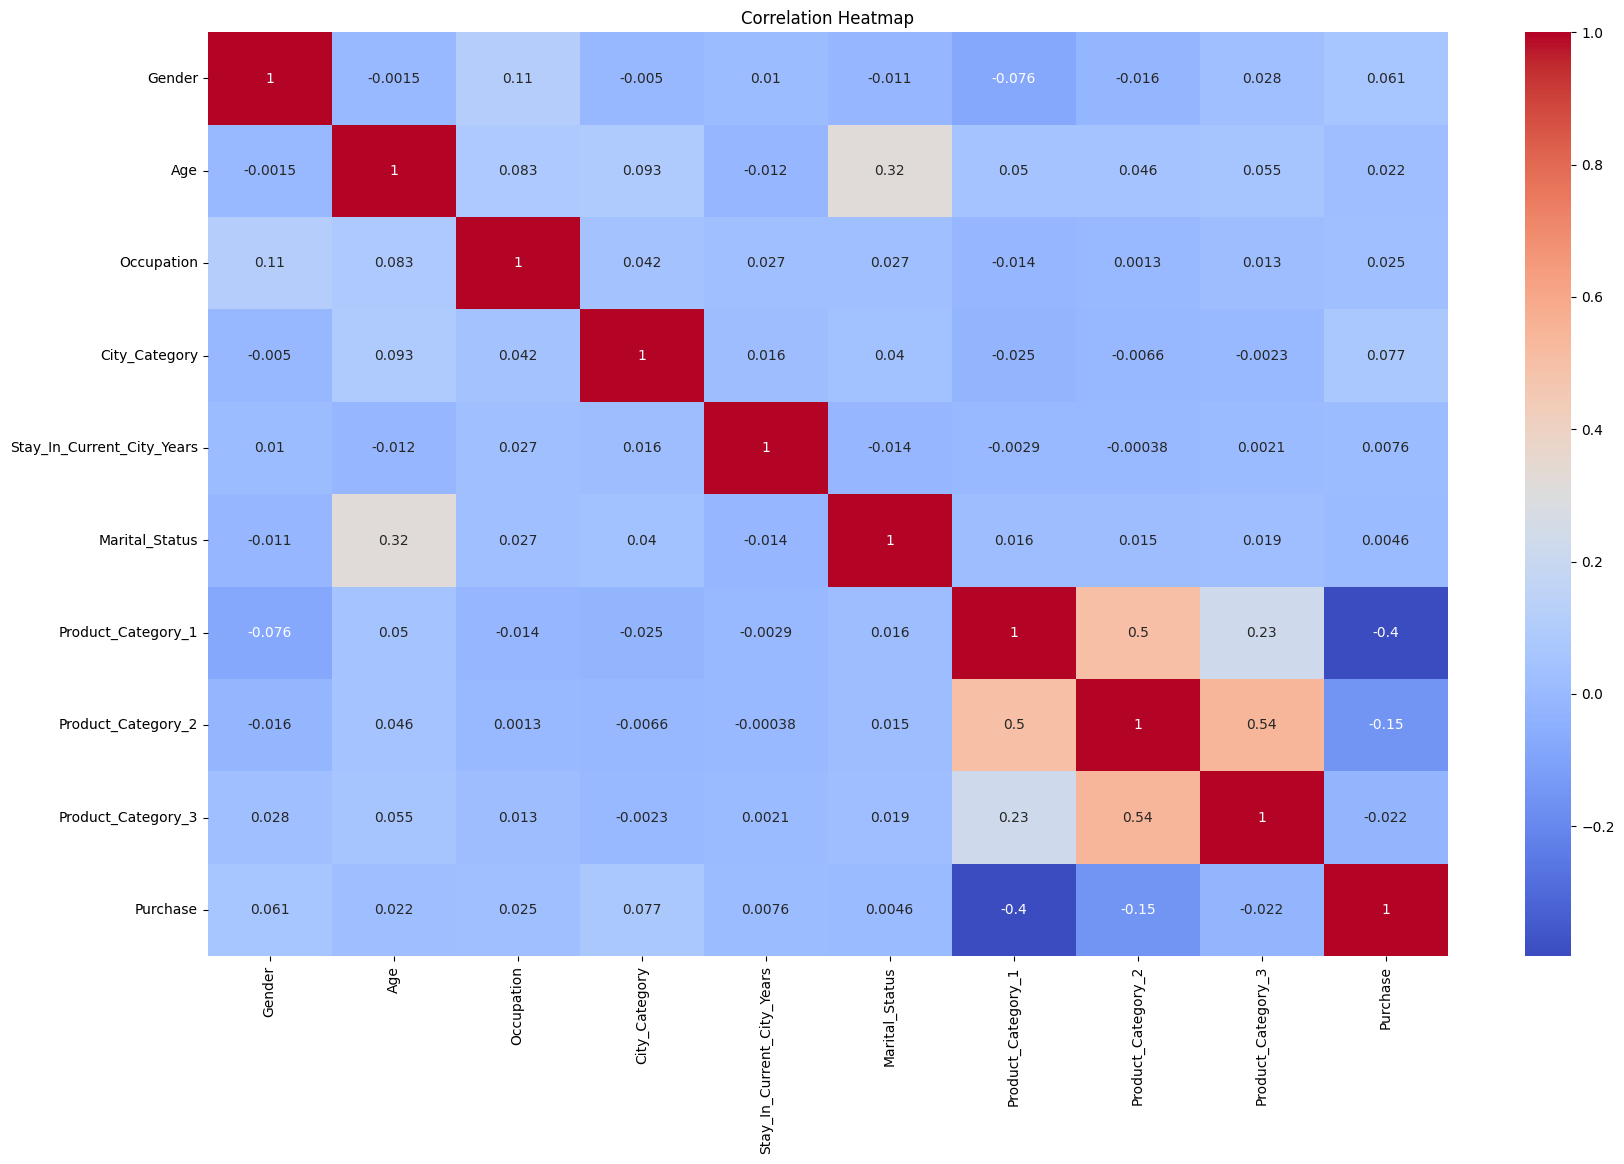

In [14]:
correlation_matrix = pd_df.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# it has shown positive correlation between Product_category_1,2,3

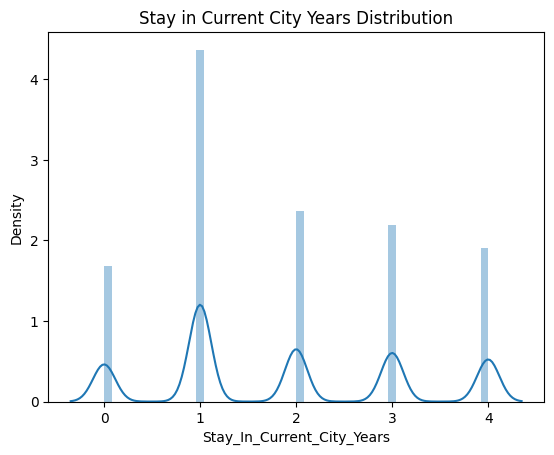

In [15]:
sns.distplot(pd_df["Stay_In_Current_City_Years"])
plt.title("Stay in Current City Years Distribution")
plt.show()

In [ ]:
# seems like new residents prefer this shop

<Axes: xlabel='Purchase', ylabel='Density'>

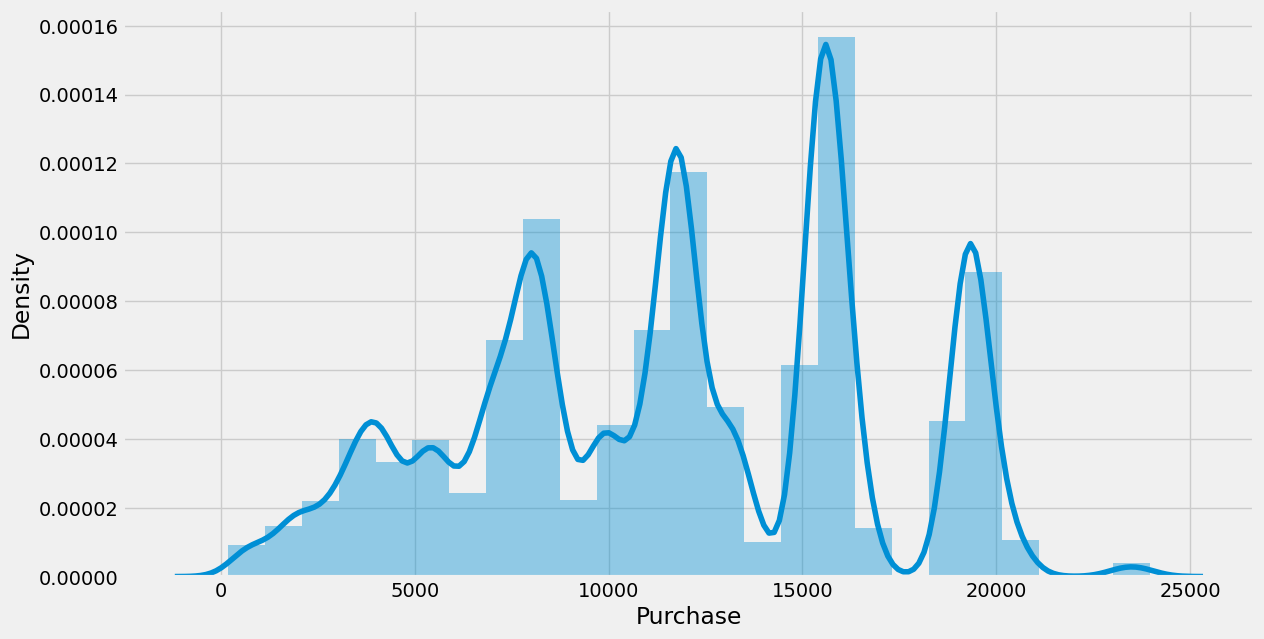

In [16]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(13, 7))
sns.distplot(pd_df['Purchase'], bins=25)

In [17]:
pd_df.Gender.value_counts()

Gender
1    129227
0     37594
Name: count, dtype: int64

<BarContainer object of 2 artists>

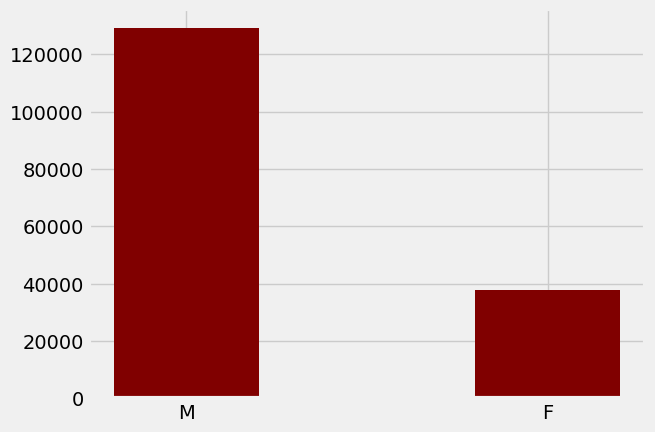

In [18]:
plt.bar(['M','F'], pd_df.Gender.value_counts().tolist(), color ='maroon', 
        width = 0.4)

In [ ]:
# seems like products in this shop are prefered by males

In [19]:
Product_Category_1_sum = pd_df.groupby('Product_Category_1')['Purchase'].sum().reset_index()

Product_Category_1_sum.sort_values(by=['Purchase'], ascending=False)

,Product_Category_1,Purchase
0,1,1254914327
1,2,183143287
5,6,131623695
2,3,127285869
4,5,121394464
6,8,68686135
7,10,32802217
3,4,13410293
8,11,8369277
11,15,2270614


In [20]:
Product_Category_2_sum = pd_df.groupby('Product_Category_2')['Purchase'].sum().reset_index()
Product_Category_2_sum.sort_values(by=['Purchase'], ascending=False)

,Product_Category_2,Purchase
0,2,589020170
5,8,310651780
2,4,203691005
12,15,177666626
3,5,167726341
4,6,153131784
11,14,109499968
8,11,65439058
10,13,58051174
7,10,37111654


In [21]:
Product_Category_3_sum = pd_df.groupby('Product_Category_3')['Purchase'].sum().reset_index()

Product_Category_3_sum.sort_values(by=['Purchase'], ascending=False)

,Product_Category_3,Purchase
12,16,391040983
11,15,345662769
2,5,201858094
13,17,196581588
10,14,185249212
4,8,163619031
5,9,120788622
8,12,80583631
9,13,71977563
3,6,64520181


In [22]:
# modeling

In [23]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Convert all features into a vector
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
output = assembler.transform(df)

# Scale features to have zero mean and unit standard deviation
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(output)
output = scalerModel.transform(output)

In [24]:
final_data = output.select("features",'Purchase') 
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [25]:
from pyspark.ml.regression import LinearRegression

# Initialize the Linear Regression model
lm = LinearRegression(featuresCol='features', labelCol='Purchase')
lm.setLabelCol("Purchase")

# Fit the model on training data
lm_model = lm.fit(train_data)

# Print the coefficients and intercept for linear regression
print("Coefficients: " + str(lm_model.coefficients))
print("Intercept: " + str(lm_model.intercept))

# Make predictions on test data
predictions = lm_model.transform(test_data)

24/06/19 20:12:45 WARN Instrumentation: [a179d63e] regParam is zero, which might cause numerical instability and overfitting.
24/06/19 20:12:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/19 20:12:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/19 20:12:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [1.238718124717968e-13,1.5300338005326106e-13,1.1650859130289631e-14,1.0753013597664475e-13,-1.3884242076541443e-13,-3.8715580550776877e-14,-5.442453803929871e-13,2.2855861000121804e-14,6.78196981351342e-14,0.9999999999999993]
Intercept: 7.668400477225115e-12


In [26]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluators
evaluator_mae = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="rmse")

# Calculate metrics
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mse = rmse**2

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 2.34665709983962e-12
R-squared: 1.0
Mean Squared Error (MSE): 9.257764055160468e-24
Root Mean Squared Error (RMSE): 3.0426574002277134e-12


In [27]:
from pyspark.ml.regression import RandomForestRegressor

# Initialize the Random Forest Regressor model
rf = RandomForestRegressor(numTrees=10, maxDepth=7, seed=42)
rf.setLabelCol("Purchase")

# Fit the model on training data
rf_model = rf.fit(train_data)

# Make predictions on test data
predictions = rf_model.transform(test_data)

# Select the prediction column
y_pred = predictions.select("prediction")

In [28]:
# Initialize evaluators
evaluator_mae = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="rmse")

# Calculate metrics
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mse = rmse**2

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 346.1072633413751
R-squared: 0.9907891686127542
Mean Squared Error (MSE): 238438.91831940418
Root Mean Squared Error (RMSE): 488.30207691489926


In [29]:
from pyspark.ml.regression import GBTRegressor

# Initialize the GBTRegressor model
xgb_reg = GBTRegressor(maxIter=480, maxDepth=8, stepSize=0.2)
xgb_reg.setLabelCol("Purchase")

# Fit the model on training data
xgb_model = xgb_reg.fit(train_data)

# Make predictions on test data
predictions = xgb_model.transform(test_data)

# Initialize evaluators
evaluator_rmse = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="r2")

# Calculate metrics
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions) * 100 # Multiply by 100 to get percentage

# Print the metrics
print("RMSE:", rmse)
print("R2 Score:", round(r2,2))

# Calculate mean of target variable
y_mean = df.select("Purchase").agg({"Purchase": "avg"}).collect()[0][0]
print("y_mean", y_mean)

24/06/19 20:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
24/06/19 20:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1024.8 KiB
24/06/19 20:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1030.8 KiB
24/06/19 20:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1031.3 KiB
24/06/19 20:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1031.8 KiB
24/06/19 20:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1033.0 KiB
24/06/19 20:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1035.2 KiB
24/06/19 20:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1039.8 KiB
24/06/19 20:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1048.8 KiB
24/06/19 20:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1067.4 KiB
24/06/19 20:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1072.9 KiB
24/06/19 20:13:33 WAR

RMSE: 129.89733433249322
R2 Score: 99.93
y_mean 11658.114979528957


In [30]:
# Initialize evaluators
evaluator_mae = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="rmse")

# Calculate metrics
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mse = rmse**2

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 77.58590061536655
R-squared: 0.9993481882772135
Mean Squared Error (MSE): 16873.31746668752
Root Mean Squared Error (RMSE): 129.89733433249322


In [ ]:
# Final Result

In [31]:
# Linear regression
# Mean Absolute Error (MAE): 7.261092811164443e-13
# R-squared: 1.0
# Mean Squared Error (MSE): 1.2225393165435908e-24
# Root Mean Squared Error (RMSE): 1.1056849987874443e-12

In [32]:
# randomforest 
# Mean Absolute Error (MAE): 356.8600933732476
# R-squared: 0.9891752780171653
# Mean Squared Error (MSE): 279075.21070652286
# Root Mean Squared Error (RMSE): 528.2756957371055

In [33]:
# xgb
# Mean Absolute Error (MAE): 78.92887900845895
# R-squared: 0.9993586867196992
# Mean Squared Error (MSE): 16533.878570983157
# Root Mean Squared Error (RMSE): 128.58413032323685

In [ ]:
# the result is to use machine learning to predict the purchase amount based on other column's value
# Linear regression sh